# Model comparison using MNIST

Shun Li, 03/07/24

## Initialize and load dataset

In [4]:
import torch
import torch.nn as nn

from EPLHb import EPLHb, gd, adam, NeuronalData

import numpy as np
from scipy import stats
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Models to be tested

Different initialization scenarios
- random initialization of every synapses
- Dale's law initialization of every synapses

Different network structure
- LHb to DAN is all inhibitory + LHb to LHb is all excitatory (if RNN)
- Every layer have mixed excitatory/inhibitory output

Different update methods
- Normal ADAM
- Fixed sign ADAM

In [5]:
LHb_network = ['MLP','RNN']
EP_LHb = ['random','dales_law']
LHb_DAN = ['real','mixed','dales_law']
update_methods = ['corelease','fixed_sign']

In [6]:
EP_size = 784 # img_size = (28,28) ---> 28*28=784 in total
LHb_size = 500 # number of nodes at hidden layer
DAN_size = 10 # number of output classes discrete range [0,9]
num_epochs = 100 # number of times which the entire dataset is passed throughout the model
num_relearn_epochs = 100
lr = 1e-2 # size of step

prob_EP_to_LHb = 1
prob_LHb_to_LHb = 1
prob_LHb_to_DAN = 1

n_networks = 1 # number of networks to train

In [7]:
# Generate data

label_type = 'digital' # or 'digital'

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

prob_EP_flip = 0.01

In [8]:
# Generate initial random data
rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': train_labels = 2*rands-1
else: train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
train_labels = torch.transpose(train_labels.repeat(DAN_size, 1).squeeze(), 0, 1)

# Randomly select inputs, and flip corresponding labels
input_mask = torch.rand(EP_size,device=device) < prob_EP_flip
flip_EP = torch.linspace(1,EP_size,EP_size)[input_mask].to(torch.int32)
flip_idx = train_data.nonzero()[torch.isin(train_data.nonzero()[:,1], flip_EP),0].unique()

train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = flip_idx.shape[0]
print('Flipped percentage: %.3f%%, %d/%d' % (100*n_flip/n_contexts, n_flip, n_contexts))
print('Flipped EP neurons: ' + str(flip_EP.numpy()))

Flipped percentage: 56.260%, 2813/5000
Flipped EP neurons: [ 52  60 283 301 442 580 728 731]


In [9]:
# Packaged into dataset
batch_size = 100

train_dataset = NeuronalData(train_data,train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

flip_dataset = NeuronalData(train_data,train_labels_flipped)
flip_loader = torch.utils.data.DataLoader(dataset=flip_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'Flipped labels')

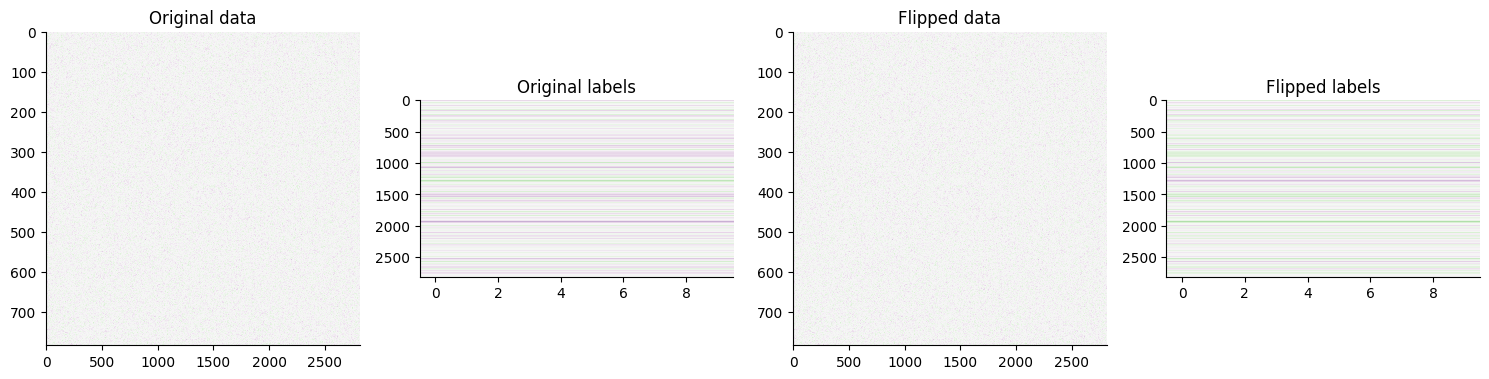

In [10]:
# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[0].set_title('Original data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels[flip_idx], cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[2].set_title('Flipped data')

if train_labels_flipped.ndim == 1: im = axs[3].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels_flipped.shape[0])
else: im = axs[3].imshow(train_labels_flipped[flip_idx], cmap='PRGn', aspect=train_labels_flipped.shape[1]/train_labels_flipped.shape[0])
axs[3].set_title('Flipped labels')

## Train models

In [11]:
training_loss_summary, relearn_loss_summary = {}, {}

for LHb in LHb_network:
    for eplhb in EP_LHb:
        for lhbdan in LHb_DAN:
            for method in update_methods:
                print('LHb: ',LHb, '; EP_LHb:',eplhb,'; LHb_DAN:',lhbdan,'; Method:',method)
                
                # Initialize network-specific loss and accuracy summary
                network_training_loss, network_relearn_loss = [], []

                # Initialize network params
                if LHb == 'MLP': rnn = False
                else: rnn = True
                if method == 'corelease': fixed_sign_update = False
                else: fixed_sign_update = True

                # Train n_networks networks
                for i in range(1,n_networks+1):
                    # Initialize a network
                    net = EPLHb(EP_size,LHb_size,DAN_size,
                                LHb_rnn=rnn,EP_LHb=eplhb,LHb_DAN=lhbdan,
                                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
                    if torch.cuda.is_available(): net.cuda()

                    training_loss, relearn_loss = [], []

                    # Train on original data
                    optimizer = adam(net.parameters(), lr=lr, fixed_sign=fixed_sign_update)
                    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
                    training_loss, _ = net.train_model(num_epochs,train_loader,optimizer,
                                                    print_epoch=False,loss='MSE')

                    # Train on flipped data
                    optimizer = adam(net.parameters(), lr=lr, fixed_sign=fixed_sign_update)
                    relearn_loss, _ = net.train_model(num_relearn_epochs,flip_loader,optimizer,
                                                    print_epoch=False,loss='MSE')

                    network_training_loss.append(training_loss)
                    network_relearn_loss.append(relearn_loss)
                    print('Finished training network %d/%d' %(i,n_networks))

                # Convert list to numpy array
                network_training_loss = np.array(network_training_loss)
                network_relearn_loss = np.array(network_relearn_loss)

                # Store name and stats of network to summary
                network_name = LHb+'_'+eplhb+'_'+lhbdan+'_'+method
                training_loss_summary[network_name] = network_training_loss
                relearn_loss_summary[network_name] = network_relearn_loss

LHb:  MLP ; EP_LHb: random ; LHb_DAN: real ; Method: corelease
Finished training network 1/1
LHb:  MLP ; EP_LHb: random ; LHb_DAN: real ; Method: fixed_sign
Finished training network 1/1
LHb:  MLP ; EP_LHb: random ; LHb_DAN: mixed ; Method: corelease
Finished training network 1/1
LHb:  MLP ; EP_LHb: random ; LHb_DAN: mixed ; Method: fixed_sign
Finished training network 1/1
LHb:  MLP ; EP_LHb: random ; LHb_DAN: dales_law ; Method: corelease
Finished training network 1/1
LHb:  MLP ; EP_LHb: random ; LHb_DAN: dales_law ; Method: fixed_sign
Finished training network 1/1
LHb:  MLP ; EP_LHb: dales_law ; LHb_DAN: real ; Method: corelease
Finished training network 1/1
LHb:  MLP ; EP_LHb: dales_law ; LHb_DAN: real ; Method: fixed_sign
Finished training network 1/1
LHb:  MLP ; EP_LHb: dales_law ; LHb_DAN: mixed ; Method: corelease
Finished training network 1/1
LHb:  MLP ; EP_LHb: dales_law ; LHb_DAN: mixed ; Method: fixed_sign
Finished training network 1/1
LHb:  MLP ; EP_LHb: dales_law ; LHb_DAN

In [12]:
# Save as pickle file
# from datetime import date

# today = date.today()
# filename = 'results/Random/model_comparison_'+today.strftime("%Y%m%d")+'.pkl'
# print('Saving to',filename)

# with open(filename, 'wb') as f:
#     data = [training_loss_summary, relearn_loss_summary]
#     pickle.dump(data, f)

# print('Done')

## Summary analysis

In [13]:
# # Optinal: load pickle file
# date = '20240313'
# filename = 'results/Random/'+date+'/model_comparison_'+date+'.pkl'
# with open(filename, 'rb') as f:
#     loaded_dict = pickle.load(f)

# training_loss_summary, relearn_loss_summary = loaded_dict

# LHb_network = ['MLP','RNN']
# initialization = ['random','dales_law']
# network_struct = ['real','mixed']
# update_methods = ['corelease','fixed_sign']

/Users/shunli/miniconda3/envs/eplhbmodel/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/shunli/miniconda3/envs/eplhbmodel/lib/python3.12/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


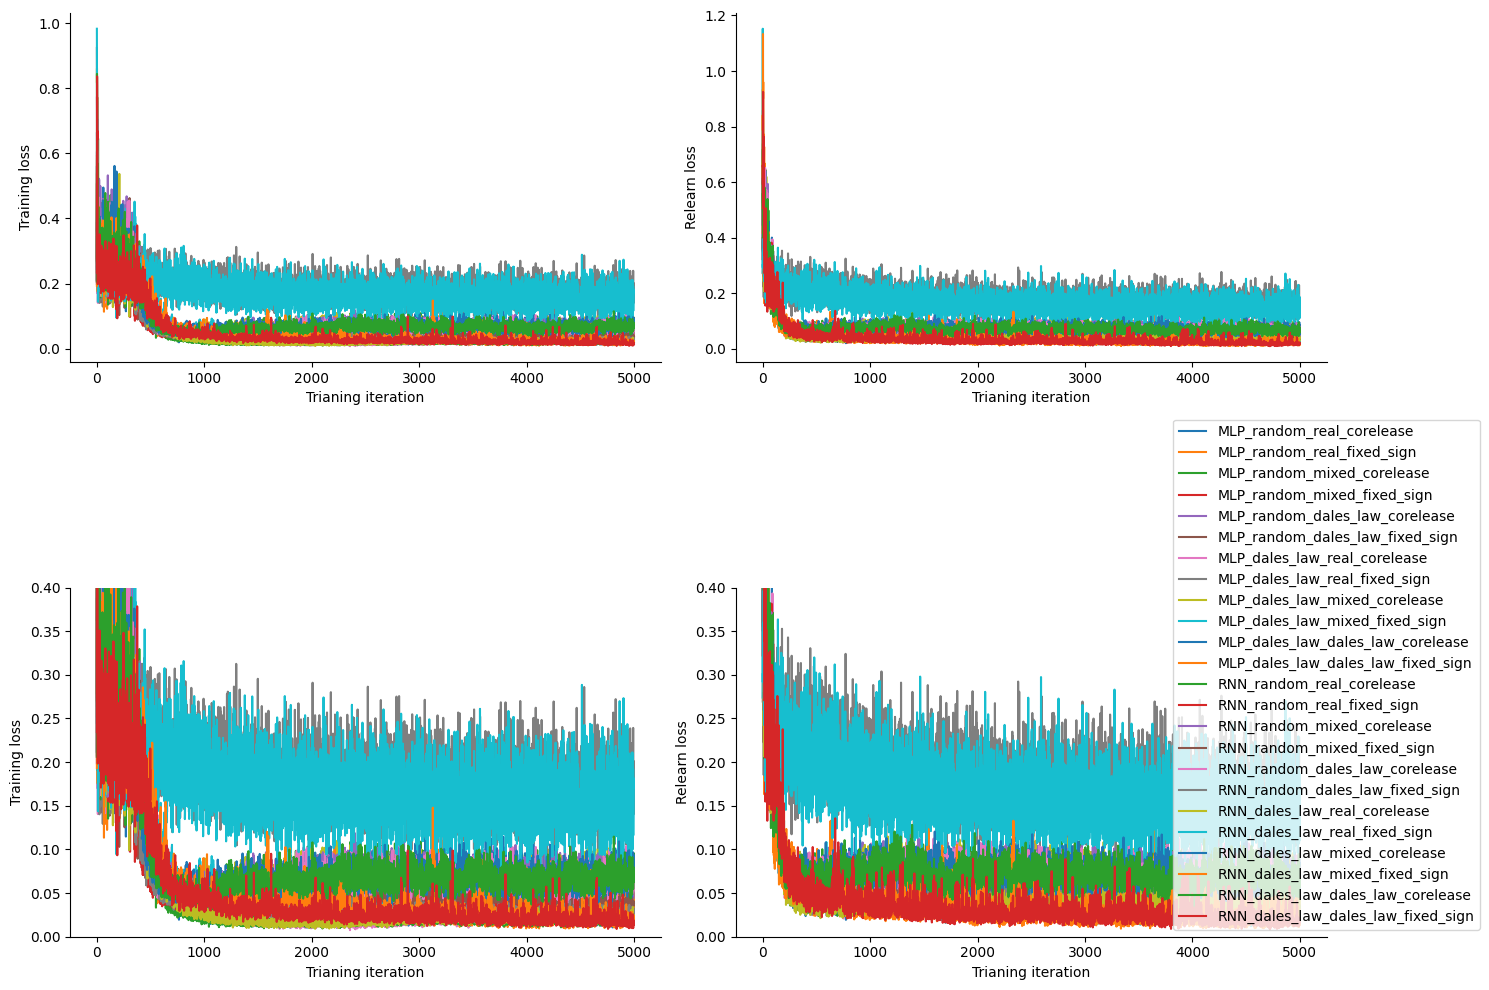

In [14]:
# Plot loss and accuracy for each network

fig, axs = plt.subplots(2,2,figsize=(15, 10))

for network in training_loss_summary:
    # print(network)
    mean_tloss = np.mean(training_loss_summary[network],axis=0)
    sem_tloss = stats.sem(training_loss_summary[network])
    mean_rloss = np.mean(relearn_loss_summary[network],axis=0)
    sem_rloss = stats.sem(relearn_loss_summary[network])

    x = np.linspace(1,mean_tloss.shape[0],num=mean_tloss.shape[0],dtype='int32')
    axs[0,0].plot(mean_tloss, label=network)
    axs[0,0].fill_between(x,mean_tloss+sem_tloss,mean_tloss-sem_tloss,alpha=0.2)
    axs[0,0].set_xlabel('Trianing iteration')
    axs[0,0].set_ylabel('Training loss')
    # axs[0,0].legend()

    axs[1,0].plot(mean_tloss, label=network)
    axs[1,0].fill_between(x,mean_tloss+sem_tloss,mean_tloss-sem_tloss,alpha=0.2)
    axs[1,0].set_xlabel('Trianing iteration')
    axs[1,0].set_ylabel('Training loss')
    axs[1,0].set_ylim([0, 0.4])
    # axs[1,0].legend()

    # Plot accuracy
    x = np.linspace(1,mean_rloss.shape[0],num=mean_rloss.shape[0],dtype='int32')
    axs[0,1].plot(mean_rloss, label=network)
    axs[0,1].fill_between(x,mean_rloss+sem_rloss,mean_rloss-sem_rloss,alpha=0.2)
    axs[0,1].set_xlabel('Trianing iteration')
    axs[0,1].set_ylabel('Relearn loss')
    # axs[0,1].legend()

    axs[1,1].plot(mean_rloss, label=network)
    axs[1,1].fill_between(x,mean_rloss+sem_rloss,mean_rloss-sem_rloss,alpha=0.2)
    axs[1,1].set_xlabel('Trianing iteration')
    axs[1,1].set_ylabel('Relearn loss')
    axs[1,1].set_ylim([0, 0.4])
    # axs[1,1].legend()


plt.legend(bbox_to_anchor=(1, 0), loc='lower center')
plt.show()
    

In [15]:
mean_tloss, mean_rloss = [],[]
for network in training_loss_summary:
    mean_tloss.append(np.mean(training_loss_summary[network],axis=1))
for network in relearn_loss_summary:
    mean_rloss.append(np.mean(relearn_loss_summary[network],axis=1))

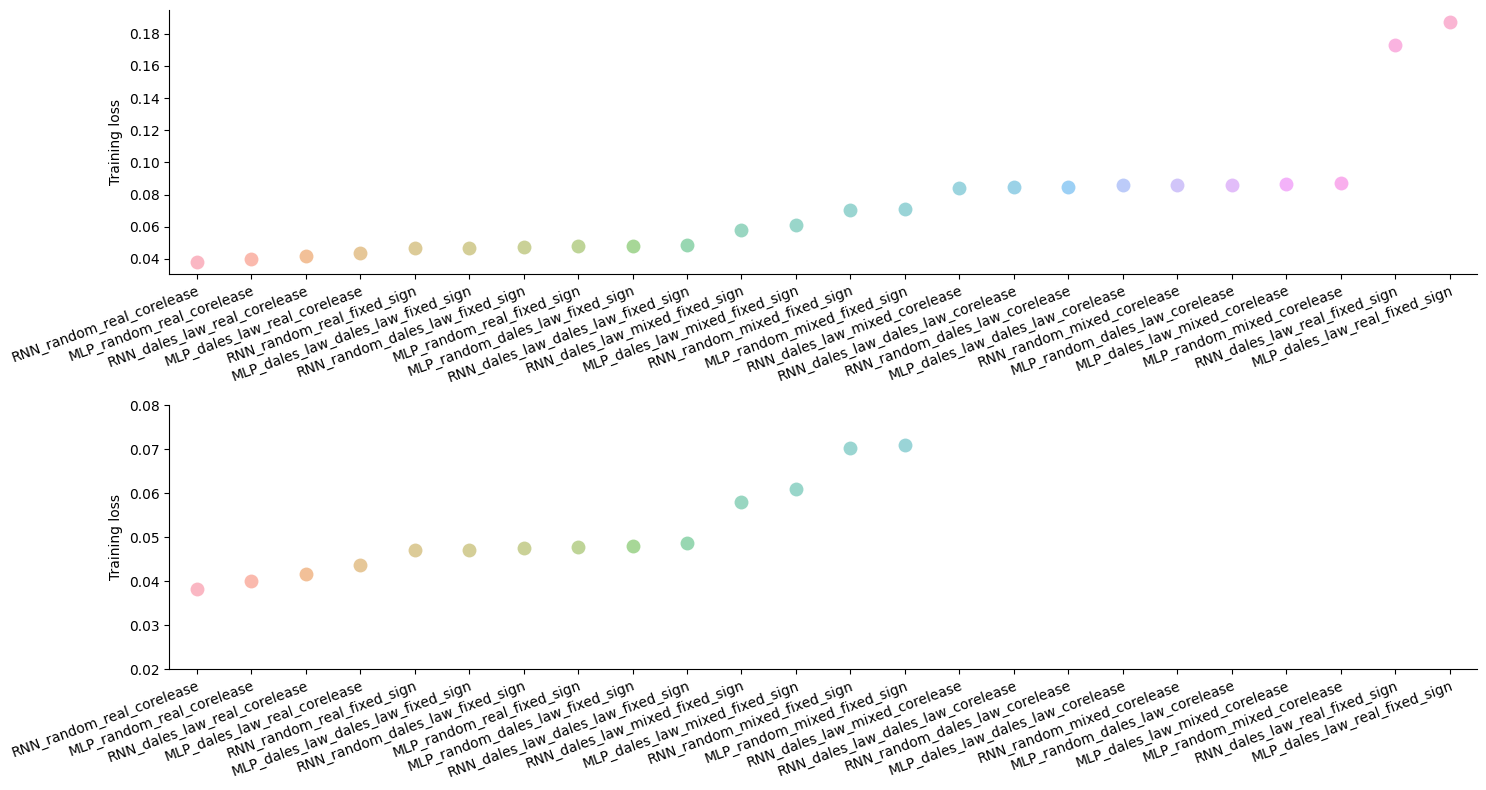

In [16]:
# Plot bar plots of different conditions

fig, axs = plt.subplots(2,1,figsize=(15, 8))
label_rotation = 20

# Sort loss
sorted_idx = np.argsort(np.mean(mean_tloss,axis=1))
mean_tloss_sorted = np.array(mean_tloss)[sorted_idx].T
sorted_keys_loss = np.array(list(training_loss_summary.keys()))[sorted_idx]
# Plot loss
sns.violinplot(data=mean_tloss_sorted, ax=axs[0],saturation=0.5,linewidth=0)
sns.stripplot(data=mean_tloss_sorted, ax=axs[0], s=10, alpha=0.5)
axs[0].set_xticks(np.arange(len(sorted_keys_loss)))
axs[0].set_xticklabels(sorted_keys_loss)
axs[0].set_ylabel('Training loss')
plt.setp(axs[0].get_xticklabels(), rotation=label_rotation, ha="right",rotation_mode="anchor")


# Plot with zoomed in y-axis
# Plot loss
# axs[1].violinplot(mean_tloss_sorted)
sns.violinplot(data=mean_tloss_sorted, ax=axs[1],saturation=0.5,linewidth=0)
sns.stripplot(data=mean_tloss_sorted, ax=axs[1], s=10, alpha=0.5)
axs[1].set_xticks(np.arange(len(sorted_keys_loss)))
axs[1].set_xticklabels(sorted_keys_loss)
axs[1].set_ylabel('Training loss')
axs[1].set_ylim([0.02,0.08])
plt.setp(axs[1].get_xticklabels(), rotation=label_rotation, ha="right",rotation_mode="anchor")

plt.show()


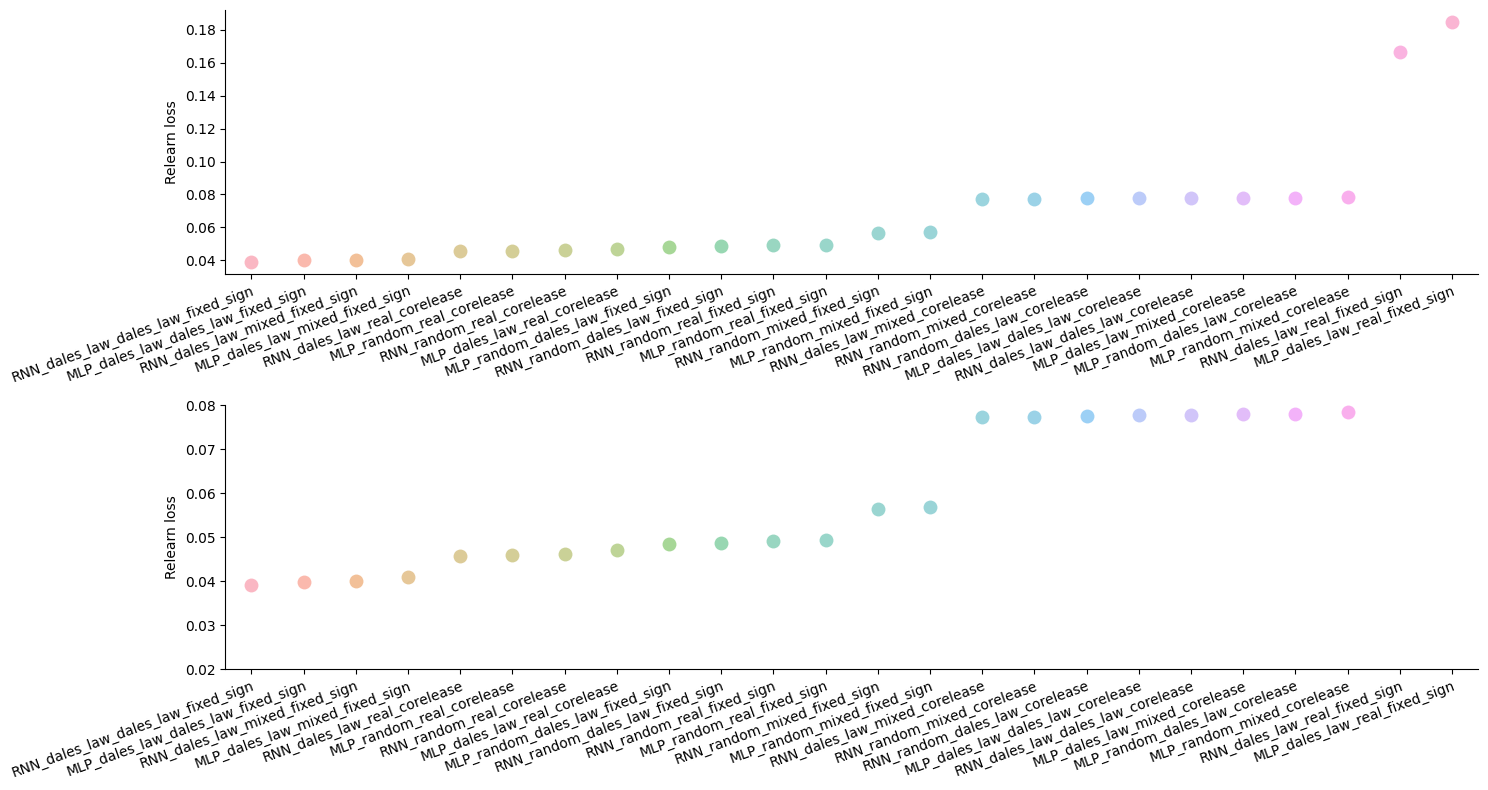

In [17]:
# Plot bar plots of accurarcy

fig, axs = plt.subplots(2,1,figsize=(15, 8))
label_rotation = 20

# Sort accuracy 
sorted_idx = np.argsort(np.mean(mean_rloss,axis=1))
mean_rloss_sorted = np.array(mean_rloss)[sorted_idx].T
sorted_keys_rloss = np.array(list(relearn_loss_summary.keys()))[sorted_idx]
# Plot accuracy
sns.violinplot(data=mean_rloss_sorted, ax=axs[0],saturation=0.5,linewidth=0)
sns.stripplot(data=mean_rloss_sorted, ax=axs[0], s=10, alpha=0.5)
axs[0].set_xticks(np.arange(len(sorted_keys_rloss)))
axs[0].set_xticklabels(sorted_keys_rloss)
axs[0].set_ylabel('Relearn loss')
plt.setp(axs[0].get_xticklabels(), rotation=label_rotation, ha="right",rotation_mode="anchor")

# Plot accuracy
sns.violinplot(data=mean_rloss_sorted, ax=axs[1],saturation=0.5,linewidth=0)
sns.stripplot(data=mean_rloss_sorted, ax=axs[1], s=10, alpha=0.5)
axs[1].set_xticks(np.arange(len(sorted_keys_rloss)))
axs[1].set_xticklabels(sorted_keys_rloss)
axs[1].set_ylabel('Relearn loss')
axs[1].set_ylim([0.02,0.08])
plt.setp(axs[1].get_xticklabels(), rotation=label_rotation, ha="right",rotation_mode="anchor")
plt.show()

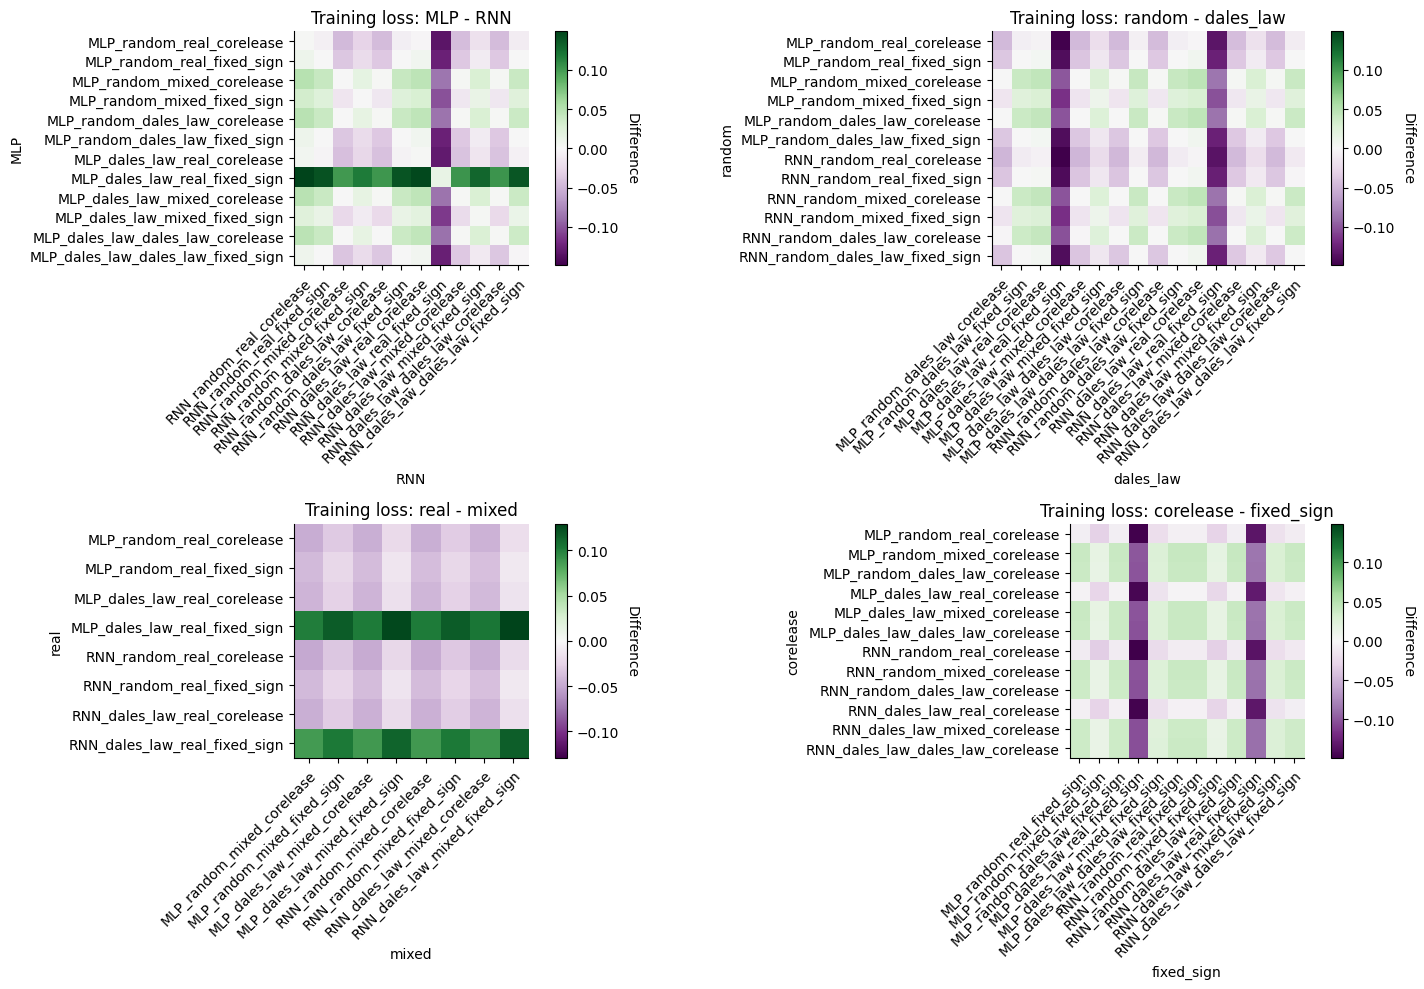

In [18]:
# Plot heatmaps to plot differences between conditions

fig, axs = plt.subplots(2,2,figsize=(15, 10))

conditions = [LHb_network, EP_LHb, LHb_DAN, update_methods]

for i, condition in enumerate(conditions):
    # Choose network that satisfies condition
    cond_1 = condition[0]
    cond_1_networks = [network for network in training_loss_summary if cond_1 in network]
    cond_2 = condition[1]
    cond_2_networks = [network for network in training_loss_summary if cond_2 in network]

    x = np.array(np.mean([np.mean(training_loss_summary[network],axis=1) for network in cond_1_networks],axis=1)).squeeze()
    y = np.array(np.mean([np.mean(training_loss_summary[network],axis=1) for network in cond_2_networks],axis=1)).squeeze()

    x_reshape = x[:,np.newaxis]
    y_reshape = y[np.newaxis,:]
    diff = x_reshape - y_reshape

    # Plot heatmap
    im = axs[i//2,i%2].imshow(diff, cmap='PRGn',vmax=abs(diff).max(), vmin=-abs(diff).max())
    axs[i//2,i%2].set_xticks(np.arange(len(cond_2_networks)))
    axs[i//2,i%2].set_yticks(np.arange(len(cond_1_networks)))
    axs[i//2,i%2].set_xticklabels(cond_2_networks)
    axs[i//2,i%2].set_yticklabels(cond_1_networks)
    axs[i//2,i%2].set_xlabel(cond_2)
    axs[i//2,i%2].set_ylabel(cond_1)
    # Rotate the tick labels and set their alignment.
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Set colorbar
    cbar = axs[i//2,i%2].figure.colorbar(im, ax=axs[i//2,i%2])
    cbar.ax.set_ylabel('Difference', rotation=-90, va="bottom")
    # Set title
    axs[i//2,i%2].set_title('Training loss: '+cond_1+' - '+cond_2)

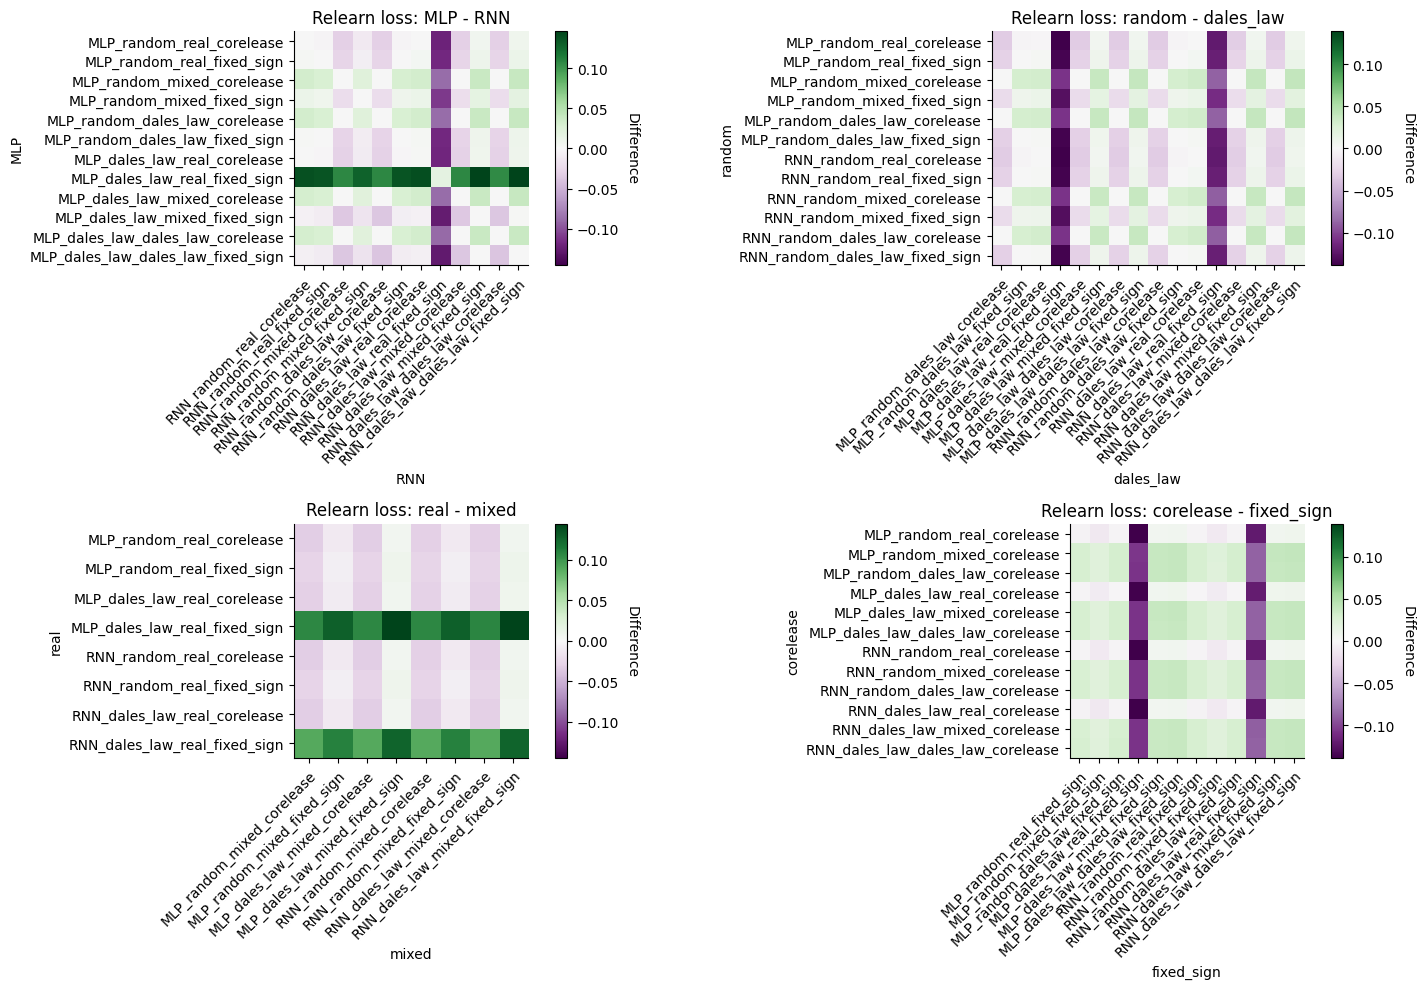

In [20]:
# Plot heatmaps to plot differences between conditions

fig, axs = plt.subplots(2,2,figsize=(15, 10))

conditions = [LHb_network, EP_LHb, LHb_DAN, update_methods]

for i, condition in enumerate(conditions):
    # Choose network that satisfies condition
    cond_1 = condition[0]
    cond_1_networks = [network for network in training_loss_summary if cond_1 in network]
    cond_2 = condition[1]
    cond_2_networks = [network for network in training_loss_summary if cond_2 in network]

    x = np.array(np.mean([np.mean(relearn_loss_summary[network],axis=1) for network in cond_1_networks],axis=1)).squeeze()
    y = np.array(np.mean([np.mean(relearn_loss_summary[network],axis=1) for network in cond_2_networks],axis=1)).squeeze()
    # x = np.linspace(1,8,num=8,dtype='int32')
    # y = np.linspace(0,1,num=8,dtype='int32')

    x_reshape = x[:,np.newaxis]
    y_reshape = y[np.newaxis,:]
    diff = x_reshape - y_reshape

    # Plot heatmap
    im = axs[i//2,i%2].imshow(diff, cmap='PRGn',vmax=abs(diff).max(), vmin=-abs(diff).max())
    axs[i//2,i%2].set_xticks(np.arange(len(cond_2_networks)))
    axs[i//2,i%2].set_yticks(np.arange(len(cond_1_networks)))
    axs[i//2,i%2].set_xticklabels(cond_2_networks)
    axs[i//2,i%2].set_yticklabels(cond_1_networks)
    axs[i//2,i%2].set_xlabel(cond_2)
    axs[i//2,i%2].set_ylabel(cond_1)
    # Rotate the tick labels and set their alignment.
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Set colorbar
    cbar = axs[i//2,i%2].figure.colorbar(im, ax=axs[i//2,i%2])
    cbar.ax.set_ylabel('Difference', rotation=-90, va="bottom")
    # Set title
    axs[i//2,i%2].set_title('Relearn loss: '+cond_1+' - '+cond_2)

## Old code